# Lecture 5 Exercise

Write a program that generates carrier modulated CA code power spectrum, auto-correlation and cross correlation. The sampling rate can be assumed to be 5MHz. You can also assume that carrier frequency is down-converted to 1.25MHz. We will discuss down-conversion in next week’s lecture.

In [1]:
import numpy as np
import utils.signals.gps_l1ca
import scipy.signal
import itertools
import matplotlib.pyplot as plt

f_samp = 5e6  # 5 MHz
f_if = 1.25e6  # 1.25 MHz IF

sim_duration = 0.02  # seconds

time_arr = np.arange(0, sim_duration, 1 / f_samp)  # time array
num_samples = len(time_arr)

print("Number of samples in", sim_duration, "seconds:", num_samples)

prn = 1
ca_code_seq = utils.signals.gps_l1ca.get_GPS_L1CA_code_sequence(prn)
# convert from {0, 1} to {-1, +1}
ca_code_seq = 1 - 2 * ca_code_seq
ca_code_rate = 1.023e6  # 1.023 MHz
ca_code_length = len(ca_code_seq)  # 1023 chips
samples_per_code_chip = f_samp / ca_code_rate

Number of samples in 0.02 seconds: 100000


In [2]:
signal_arr = np.cos(2 * np.pi * f_if * time_arr) * (
    ca_code_seq[(time_arr * f_samp / samples_per_code_chip).astype(int) % ca_code_length]
)

The power spectral density can be computed using the `scipy.signal.welch` function.

In [3]:
psd_freq_arr, psd_arr = scipy.signal.welch(signal_arr, fs=f_samp, nperseg=1024)

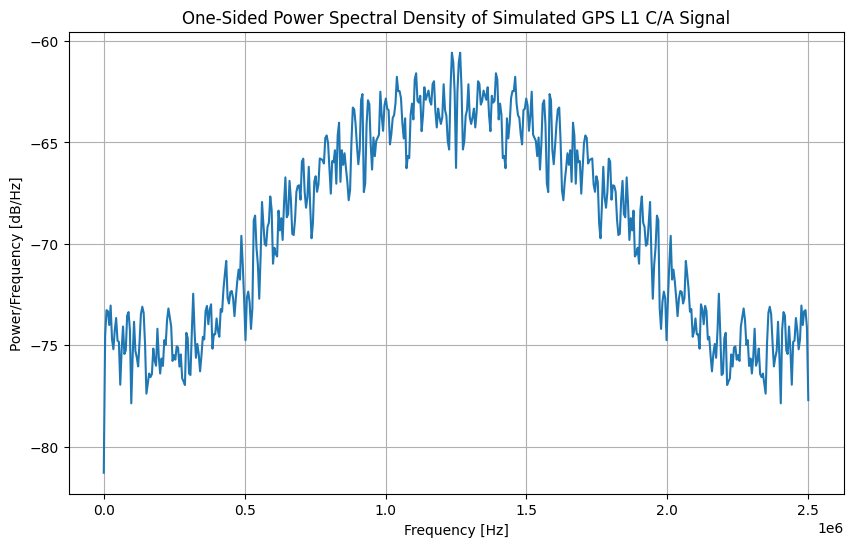

In [4]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(psd_freq_arr, 10 * np.log10(psd_arr))
ax.grid()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Power/Frequency [dB/Hz]")
ax.set_title("One-Sided Power Spectral Density of Simulated GPS L1 C/A Signal")
plt.show()

The CA code autocorrelation and cross-correlation sequences.

In [9]:
prn_list = [1, 7, 11]
corr_seqs = {}
num_repeats = 4
for prn_a, prn_b in itertools.combinations_with_replacement(prn_list, 2):
    ca_code_seq_a = utils.signals.gps_l1ca.get_GPS_L1CA_code_sequence(prn_a)
    ca_code_seq_b = utils.signals.gps_l1ca.get_GPS_L1CA_code_sequence(prn_b)
    # convert from {0, 1} to {-1, +1}
    ca_code_seq_a = 1 - 2 * ca_code_seq_a
    ca_code_seq_b = 1 - 2 * ca_code_seq_b
    # upsample to demonstrate that correlation of rectangle pulse code has linear slopes
    ca_code_seq_a = ca_code_seq_a.repeat(num_repeats)
    ca_code_seq_b = ca_code_seq_b.repeat(num_repeats)
    # apply circular correlation using FFTs
    corr_seq = np.fft.ifft(np.fft.fft(ca_code_seq_a) * np.conj(np.fft.fft(ca_code_seq_b))).real
    corr_seqs[(prn_a, prn_b)] = corr_seq

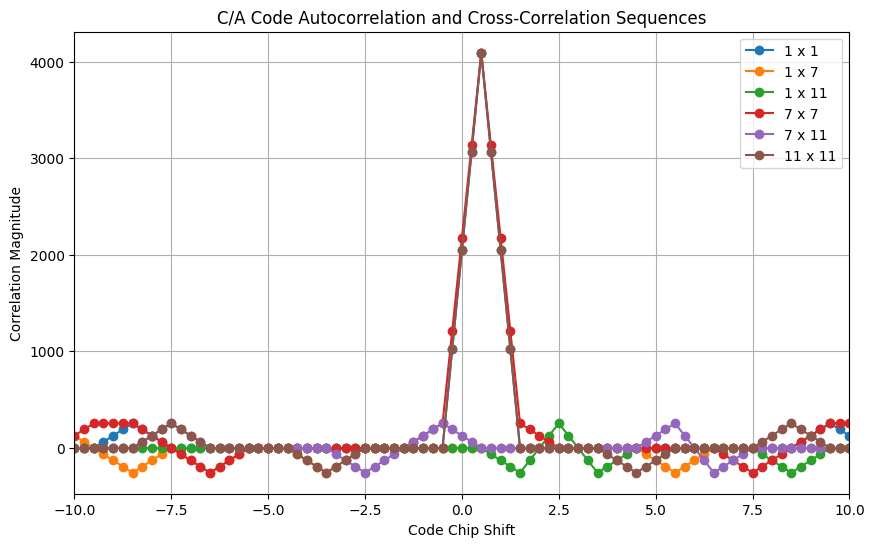

In [11]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
chip_arr = np.arange(ca_code_length * num_repeats) / num_repeats
shifted_chip_arr = chip_arr - ca_code_length // 2
for (prn_a, prn_b), corr_seq in corr_seqs.items():
    shifted_corr_seq = np.fft.fftshift(corr_seq)
    ax.plot(shifted_chip_arr, shifted_corr_seq, marker="o", label=f"{prn_a} x {prn_b}")
ax.legend()
ax.grid()
ax.set_xlabel("Code Chip Shift")
ax.set_ylabel("Correlation Magnitude")
ax.set_title("C/A Code Autocorrelation and Cross-Correlation Sequences")
ax.set_xlim(-10, 10)
# ax.set_ylim(-70, 70)
plt.show()